In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import warnings
%matplotlib inline

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [26]:
# EVALUATION METRICS
def cindex(y_true_times, predicted_times, tol=1e-8):
    """
    Author: Romuald Menuet & Rémy Dubois

    Evaluate concordance index from Pandas DataFrame, taking ties into account.

    Args:
        y_true_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `Event` and `SurvivalTime` the float-valued column of true survival times.
        predicted_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `SurvivalTime` the float-valued column of predicted survival times,
            and one `Event`column, whose value does not matter. It must be appended so that target and predictions have the same format.
        tol: float
            small float value for numerical stability.
    Returns:
        Concordance index, as described here:
        https://square.github.io/pysurvival/metrics/c_index.html
    """

    assert isinstance(y_true_times, pd.DataFrame), 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert isinstance(predicted_times, pd.DataFrame), 'Predicted times should be pd dataframe with patient `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(y_true_times.shape) == 2, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(predicted_times.shape) == 2, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(y_true_times.columns) == {'Event', 'SurvivalTime'}, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(predicted_times.columns) == {'Event', 'SurvivalTime'}, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    np.testing.assert_equal(y_true_times.shape, predicted_times.shape, err_msg="Not same amount of predicted versus true samples")
    assert set(y_true_times.index) == set(predicted_times.index), 'Not same patients in prediction versus ground truth'
    assert np.all(predicted_times['SurvivalTime'] > 0), 'Predicted times should all be positive'

    events = y_true_times.Event
    y_true_times = y_true_times.SurvivalTime
    predicted_times = predicted_times.SurvivalTime

    # Just ordering the right way
    predicted_times = predicted_times.loc[y_true_times.index]
    events = events.loc[y_true_times.index]

    events = events.values.astype(int)
    y_true_times = y_true_times.values.astype(float)
    predicted_times = predicted_times.values.astype(float)
    # events = events.values.astype(bool)

    np.testing.assert_array_less(1.,
                                 predicted_times.astype(float),
                                 err_msg="Predicted y_true_times all below 1.\
                                 It should be in days. Make sure that you are not predicting risk instead of time.")

    return _cindex_np(y_true_times, predicted_times, events)


def _cindex_np(times, predicted_times, events, tol=1.e-8):
    """
    Raw CI computation from np arrray. Should not be used as is.
    """
    assert times.ndim == predicted_times.ndim == events.ndim == 1, "wrong input, should be vectors only"
    assert times.shape[0] == predicted_times.shape[0] == events.shape[0], "wrong input, should be vectors of the same len"

    risks = - predicted_times

    risks_i = risks.reshape((-1, 1))
    risks_j = risks.reshape((1, -1))
    times_i = times.reshape((-1, 1))
    times_j = times.reshape((1, -1))
    events_i = events.reshape((-1, 1))

    eligible_pairs = (times_i < times_j) * events_i

    well_ordered = np.sum(eligible_pairs * (risks_i > risks_j))
    ties = + np.sum(eligible_pairs * 0.5 * (risks_i == risks_j))

    return (well_ordered + ties) / (eligible_pairs.sum() + tol)

## Images

In [2]:
train_path = '../files_provided/data/train/'
test_path = '../files_provided/data/test/'
# getting a list of each patient
patients = os.listdir(train_path+'/images')
patients.sort()
patients

['patient_002.npz',
 'patient_003.npz',
 'patient_004.npz',
 'patient_005.npz',
 'patient_007.npz',
 'patient_008.npz',
 'patient_011.npz',
 'patient_014.npz',
 'patient_015.npz',
 'patient_016.npz',
 'patient_017.npz',
 'patient_018.npz',
 'patient_020.npz',
 'patient_021.npz',
 'patient_022.npz',
 'patient_023.npz',
 'patient_024.npz',
 'patient_025.npz',
 'patient_026.npz',
 'patient_029.npz',
 'patient_030.npz',
 'patient_031.npz',
 'patient_032.npz',
 'patient_033.npz',
 'patient_035.npz',
 'patient_036.npz',
 'patient_037.npz',
 'patient_039.npz',
 'patient_040.npz',
 'patient_042.npz',
 'patient_043.npz',
 'patient_044.npz',
 'patient_045.npz',
 'patient_047.npz',
 'patient_048.npz',
 'patient_051.npz',
 'patient_052.npz',
 'patient_053.npz',
 'patient_056.npz',
 'patient_057.npz',
 'patient_058.npz',
 'patient_061.npz',
 'patient_063.npz',
 'patient_064.npz',
 'patient_067.npz',
 'patient_068.npz',
 'patient_069.npz',
 'patient_070.npz',
 'patient_072.npz',
 'patient_073.npz',


(92, 92, 92)


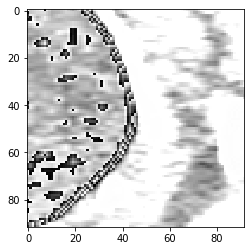

In [3]:
# Checking an image
archive = np.load(train_path + '/images/'+ 'patient_002.npz')
scan = archive['scan']
mask = archive['mask']
print(scan.shape)
# print(scan)

# Viewing the image
img = Image.fromarray(scan,'LA')
imshow(img)

In [4]:
# train_images
# for patient in patients:
#     archive = np.load(train_images_path + '/'+ patient)
#     scan = archive['scan']
#     mask = archive['mask']
# scan

## Other Features in CSVs
- $Clinical Data$: basic meta-information for each patient
- $Radiomics features$: hand crafted features from the tumoral zone by experts 

In [17]:
df_clinical = pd.read_csv(train_path+'features/clinical_data.csv')
# df.head()
# df_clinical = df_clinical.sort_values('PatientID')
print(df_clinical.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
PatientID        300 non-null int64
Histology        280 non-null object
Mstage           300 non-null int64
Nstage           300 non-null int64
SourceDataset    300 non-null object
Tstage           300 non-null int64
age              284 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 16.5+ KB
None


In [19]:
df_clinical.head()

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,202,Adenocarcinoma,0,0,l2,2,66.0000
1,371,large cell,0,2,l1,4,64.5722
2,246,squamous cell carcinoma,0,3,l1,2,66.0452
3,240,nos,0,2,l1,3,59.3566
4,284,squamous cell carcinoma,0,3,l1,4,71.0554


In [6]:
df_radiomics = pd.read_csv(train_path + 'features/radiomics.csv',skiprows=[0,2])
df_radiomics.columns.values[0] = "PatientID"
# df_radiomics = df_radiomics.sort_values('PatientID')
df_radiomics = df_radiomics.sort_values('PatientID')
df_radiomics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 115 to 77
Data columns (total 54 columns):
PatientID                                       300 non-null int64
original_shape_Compactness1                     300 non-null float64
original_shape_Compactness2                     300 non-null float64
original_shape_Maximum3DDiameter                300 non-null float64
original_shape_SphericalDisproportion           300 non-null float64
original_shape_Sphericity                       300 non-null float64
original_shape_SurfaceArea                      300 non-null float64
original_shape_SurfaceVolumeRatio               300 non-null float64
original_shape_VoxelVolume                      300 non-null float64
original_firstorder_Energy                      300 non-null float64
original_firstorder_Entropy                     300 non-null float64
original_firstorder_Kurtosis                    300 non-null float64
original_firstorder_Maximum                     300 non-null float64

In [20]:
df_radiomics.head()

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
115,2,0.024239,0.208753,100.682670,1.685735,0.593213,26352.063215,0.143385,183911.0,1.823932e+09,...,4.681262,20051.589877,54352.774029,0.608142,0.000918,1342.009256,0.000710,938.104181,0.003537,6567.332842
258,3,0.014520,0.074913,178.117938,2.372178,0.421554,3007.456844,0.708512,4352.0,9.350766e+08,...,1.194862,121.860389,3683.000792,0.943351,0.004979,731.875365,0.004741,695.615307,0.006145,901.956835
158,4,0.022972,0.187502,133.895482,1.747154,0.572359,19410.111759,0.176282,110220.0,6.019421e+09,...,2.776563,3687.540945,53820.687146,0.740312,0.001657,1431.057216,0.001459,1208.546317,0.003430,3740.268350
281,5,0.030597,0.332627,39.319207,1.443269,0.692871,2824.554343,0.346954,8177.0,7.031788e+07,...,7.285089,1006.359656,1565.874316,0.501632,0.001258,1328.848441,0.000986,816.256111,0.005828,10016.147961
150,7,0.024970,0.221540,97.989795,1.652657,0.605086,26355.120648,0.139177,189478.0,3.800057e+09,...,4.868237,17465.053523,56507.954765,0.605997,0.001264,1264.678549,0.001025,879.772376,0.004216,6675.271359


In [7]:
X_train = df_radiomics.drop(['PatientID'],axis=1).to_numpy()
X_train

array([[2.42390038e-02, 2.08752545e-01, 1.00682670e+02, ...,
        9.38104181e+02, 3.53673006e-03, 6.56733284e+03],
       [1.45203831e-02, 7.49132080e-02, 1.78117938e+02, ...,
        6.95615307e+02, 6.14528606e-03, 9.01956835e+02],
       [2.29721714e-02, 1.87502189e-01, 1.33895482e+02, ...,
        1.20854632e+03, 3.42991660e-03, 3.74026835e+03],
       ...,
       [2.05004582e-02, 1.49323920e-01, 1.11067547e+02, ...,
        1.00967590e+03, 4.62486076e-03, 8.73847993e+03],
       [2.52195095e-02, 2.25982869e-01, 8.93252484e+01, ...,
        1.62129351e+03, 2.99727754e-03, 2.39972251e+03],
       [2.28332401e-02, 1.85241092e-01, 9.10439454e+01, ...,
        9.28074629e+02, 2.74039158e-03, 2.28869662e+03]])

In [8]:
labels = pd.read_csv(train_path + '/train_labels.csv')
labels = labels.sort_values('PatientID')
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 115 to 77
Data columns (total 3 columns):
PatientID       300 non-null int64
SurvivalTime    300 non-null int64
Event           300 non-null int64
dtypes: int64(3)
memory usage: 9.4 KB


In [29]:
Y_train = labels['SurvivalTime'].values
# Y_train

In [70]:
def get_features_from_csvs(path):
    df = pd.read_csv(path + 'features/radiomics.csv',skiprows=[0,2])
    df.columns.values[0] = "PatientID"
    df = df.sort_values('PatientID')
    df = df.drop(['PatientID'],axis=1)
    return df.to_numpy()


X_train = get_features_from_csvs(train_path)
X_test = get_features_from_csvs(test_path)
print(X_train.shape, X_test.shape)

(300, 53) (125, 53)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=3)
regressor = RandomForestRegressor(n_estimators=100,min_samples_split= 5, ccp_alpha=0.06,random_state=42)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)
# p_df = pd.DataFrame(predictions, )
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))
# print(cindex(y_test,predictions))


0.8376425088627882
0.10405092491456525


## Handling missing values for age

In [11]:
nan_patients = [row['PatientID'] for i, row in df_clinical.iterrows() if np.isnan(row['age'])]
nan_patients

[79, 388, 237, 355, 294, 231, 152, 67, 138, 18, 269, 92, 228, 299, 306, 298]

In [12]:
patients_with_age = [i for i in df_clinical['PatientID'] if i not in nan_patients]

In [13]:
df_clinical.loc[df_clinical['PatientID'] == 237]
# df_clinical

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
108,237,squamous cell carcinoma,0,2,l1,4,NaN


In [14]:
train_features = np.array([row[1:].to_numpy() for i, row in df_radiomics.iterrows() if row['PatientID'] in patients_with_age])
test_features = np.array([row[1:].to_numpy() for i, row in df_radiomics.iterrows() if row['PatientID'] in nan_patients])
train_ages = np.array([row['age'] for i,row in df_clinical.iterrows() if row['PatientID'] not in nan_patients])
# train_ages

In [15]:

from sklearn.tree import DecisionTreeRegressor

# regr = RandomForestRegressor(n_estimators=300, max_depth=90, random_state=0)
# regr.fit(train_features, train_ages)
# print(regr.feature_importances_)
# print(regr.predict(test_features))
# print(regr.score(train_features, train_ages))
# regr.apply(train_features)
X_train, X_test, y_train, y_test = train_test_split(train_features, train_ages, test_size=0.2, random_state=3)

regressor = RandomForestRegressor(n_estimators=500, ccp_alpha=0.3, random_state=3)
regressor.fit(X_train, y_train)
print(regressor.score(X_test,y_test))
print(regressor.predict(X_test))
y_test

-0.21927623637843974
[67.04981808 71.84444188 70.08780505 71.87305455 61.34178801 69.29935483
 72.89242965 71.29261918 69.38703286 68.91554862 68.52627827 68.69774353
 69.93149141 74.35853759 72.52821382 63.07189545 67.97157158 63.41602447
 65.27404076 62.90496529 69.24405658 68.23089429 68.21324535 66.97677485
 67.80082729 61.27844768 57.21513962 73.00750349 69.83075501 68.69850477
 71.38030145 67.66738268 64.43575324 66.67907765 67.73795368 67.1813187
 74.86414518 64.67625422 68.57863992 69.46993708 67.83314049 63.83867362
 68.0716319  69.20270065 73.32858928 70.38314386 69.80545186 65.53257062
 72.90279277 69.73859401 74.20902358 67.81147504 65.70689043 66.81663571
 71.27503399 70.51642338 66.6502464 ]


array([70.    , 72.    , 78.0589, 68.    , 73.    , 80.1999, 62.5654,
       56.8214, 67.    , 65.    , 73.8658, 63.    , 72.    , 65.    ,
       49.3443, 56.    , 78.7789, 70.    , 62.    , 67.5866, 61.    ,
       69.    , 63.    , 72.6982, 71.8439, 65.    , 59.    , 70.4723,
       56.5969, 60.0986, 74.    , 78.601 , 78.7105, 81.    , 66.    ,
       66.0534, 62.2505, 78.    , 64.1916, 72.    , 59.3566, 79.    ,
       69.41  , 83.989 , 69.    , 67.    , 78.    , 58.1656, 80.7228,
       61.2485, 68.    , 55.447 , 62.6639, 74.    , 72.0684, 47.989 ,
       69.8645])

## Checking for clusters

# Appendix
## Radiomics
Radiomics features are designed with the goal of providing off-the-shelf quantitative features describing tumors, computed on radiology imaging data. Such features have the pros of offering quantitative and reproducible analyses. A standard pipeline for analyzing radiology imaging data could be:
- Annotating the tumoral zone by a segmentation mask
- Extracting radiomics with a certified software / library
- Plugging those features into usual machine learning / survival regression models

Designing those features requires advanced medical knowledge, and a lot of experience in prognosis / medical models. Hence, a large number of informative features have been identified by groups of medical experts in radio-oncology, related to colour or density heterogeneity, compactness, and many others.

This challenge uses a subset of 53 features which have been identified as worth-to-be-looked-at for the proposed task.


## List of radiomics used in the challenge
The below lists each feature furnished for this challenge.  
Details over each computed feature can be found at https://pyradiomics.readthedocs.io/en/v1.0/radiomics.html#

### Shape
- 'Compactness1'
- 'Compactness2'
- 'Maximum3DDiameter'
- 'SphericalDisproportion'
- 'Sphericity'
- 'SurfaceArea'
- 'SurfaceVolumeRatio'
- 'VoxelVolume'

### Firstorder
- 'Energy'
- 'Entropy'
- 'Kurtosis'
- 'Maximum'
- 'Mean'
- 'MeanAbsoluteDeviation'
- 'Median'
- 'Minimum'
- 'Range'
- 'RootMeanSquared'
- 'Skewness'
- 'StandardDeviation'
- 'Uniformity'
- 'Variance'

### Glcm:
- 'Autocorrelation'
- 'ClusterProminence'
- 'ClusterShade'
- 'ClusterTendency'
- 'Contrast'
- 'Correlation'
- 'DifferenceEntropy'
- 'DifferenceAverage' #Dissimilarity
- 'JointEnergy' 
- 'JointEntropy'
- 'Id' #homogeneity1
- 'Idm' #homogeneity1
- 'Imc1'
- 'Imc2'
- 'Idmn'
- 'Idn'
- 'InverseVariance'
- 'MaximumProbability'
- 'SumAverage'
- 'SumEntropy'

### Glrlm:
- 'ShortRunEmphasis'
- 'LongRunEmphasis'
- 'GrayLevelNonUniformity'
- 'RunLengthNonUniformity'
- 'RunPercentage'
- 'LowGrayLevelRunEmphasis'
- 'HighGrayLevelRunEmphasis'
- 'ShortRunLowGrayLevelEmphasis'
- 'ShortRunHighGrayLevelEmphasis'
- 'LongRunLowGrayLevelEmphasis'
- 'LongRunHighGrayLevelEmphasis'